In [16]:
from pydantic import BaseModel
from random import randint, choice, uniform
from tqdm import tqdm
import pandas as pd

MAX_WEIGHT = 1500
MAX_STATES = 10000
BAG_SIZE = 30


class Item(BaseModel):
    value: int
    weight: int
    state: bool = False


class Bag(BaseModel):
    items: list[Item]


def generate_item() -> Item:
    return Item(
        value=randint(1, 100),
        weight=randint(1, 200),
        state=choice([True, False]),
    )


def is_valid_state(bag: list[Item]) -> bool:
    weights = [item.weight for item in bag if item.state]
    total_weight = sum(weights)

    if total_weight > MAX_WEIGHT:
        return False

    return True


def generate_items(n: int = MAX_STATES) -> list[Item]:
    items = []
    for _ in range(BAG_SIZE):
        item = generate_item()
        items.append(item)
    return items


def generate_initial_bag(items: list[Item]) -> Bag:
    for item in items:
        entry = choice([True, False])
        item.state = entry

    return Bag(items=items)


In [17]:
def sum_weights(bag: Bag) -> int:
    weights = [item.weight for item in bag.items if item.state]
    return sum(weights)


def sum_values(bag: Bag) -> int:
    values = [item.value for item in bag.items if item.state]
    return sum(values)

In [18]:
import copy

def sub_item(bag: Bag) -> Bag:
    copy_bag = copy.deepcopy(bag)
    output_items = [idx for idx, item in enumerate(copy_bag.items) if item.state]
    input_items = [idx for idx, item in enumerate(copy_bag.items) if not item.state]

    output_item = choice(output_items)
    input_item = choice(input_items)

    copy_bag.items[output_item].state = False
    copy_bag.items[input_item].state = True


    return copy_bag

In [19]:
def min_distance(weight_next_bag: int, weight_current_bag: 0) -> int:
    diff_next = abs(MAX_WEIGHT - weight_next_bag)  
    diff_current = abs(MAX_WEIGHT - weight_current_bag) 

    return diff_next if diff_next < diff_current else diff_current


def next_is_better_value(
    current_bag: Bag, next_bag: Bag
) -> bool:
    weight_current_bag = sum_weights(current_bag)
    weight_next_bag = sum_weights(next_bag) 

    value_current_bag = sum_values(current_bag)
    value_next_bag = sum_values(next_bag)
    
    # Casos extremos
    if weight_next_bag >= weight_current_bag and value_next_bag < value_current_bag:
        return False

    if weight_next_bag < weight_current_bag and value_next_bag >= value_current_bag:
        return True 

    # Caso peso fora do limite
    if weight_next_bag > MAX_WEIGHT and weight_current_bag <= weight_next_bag:
        return False

    if weight_next_bag >= MAX_WEIGHT and weight_current_bag > weight_next_bag:
        return True

    # Caso peso dentro do limite
    elif weight_next_bag <= MAX_WEIGHT and weight_current_bag < MAX_WEIGHT:
        if (MAX_WEIGHT - weight_current_bag) < (MAX_WEIGHT - weight_next_bag) or (value_next_bag < value_current_bag):
            return False
        return True

In [20]:
INITIAL_TEMPERATURE = 100
import math 

def decaimento_logaritmico(
    current_idx: int, init_temp: int = INITIAL_TEMPERATURE, total_idx: int = 100
):
    return init_temp - 21.60 * math.log(current_idx + 1)


def randomic_annealing_value(idx: int) -> bool:
    expo = decaimento_logaritmico(current_idx=idx)
    random_value = uniform(0, 100)

    if expo > random_value: 
        return True
    return False


In [21]:
import pandas as pd 


items = generate_items()
initial_bag = generate_initial_bag(items)

results = pd.DataFrame()

for bag in tqdm(range(100)):
    data = {
        "bag": [],
        "idx": [],
        "weight_current_bag": [],
        "weight_next_bag": [],
        "value_current_bag": [],
        "value_next_bag": [],
        "next_is_better": [],
        "randomic_annealing": [],
    }

    current_bag = copy.copy(initial_bag)
    for idx in range(100):
        randomic_annealing = None
        next_bag = sub_item(current_bag)

        weight_current_bag = sum_weights(current_bag)
        weight_next_bag = sum_weights(next_bag) 

        value_current_bag = sum_values(current_bag)
        value_next_bag = sum_values(next_bag)

        next_is_better = next_is_better_value(current_bag, next_bag)

        if next_is_better:
            current_bag = next_bag
        else:
            randomic_annealing = randomic_annealing_value(idx=idx)
            if randomic_annealing:
                current_bag = next_bag

        data["bag"].append(bag)
        data["idx"].append(idx)
        data["weight_current_bag"].append(weight_current_bag)
        data["weight_next_bag"].append(weight_next_bag)
        data["value_current_bag"].append(value_current_bag)
        data["value_next_bag"].append(value_next_bag)
        data["next_is_better"].append(next_is_better)
        data["randomic_annealing"].append(randomic_annealing)

    data_df = pd.DataFrame.from_dict(data)
    results = pd.concat([results, data_df])

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 54.56it/s]


In [22]:
results.reset_index(drop=True, inplace=True)
results[0:102]

,bag,idx,weight_current_bag,weight_next_bag,value_current_bag,value_next_bag,next_is_better,randomic_annealing
0,0,0,1957,1922,638,621,True,None
1,0,1,1922,1827,621,612,True,None
2,0,2,1827,1978,612,567,False,False
3,0,3,1827,1869,612,618,False,False
4,0,4,1827,1852,612,648,False,True
...,...,...,...,...,...,...,...,...
97,0,97,1473,1564,906,925,False,False
98,0,98,1473,1588,906,906,False,False
99,0,99,1473,1476,906,916,True,None
100,1,0,1957,2015,638,707,False,True


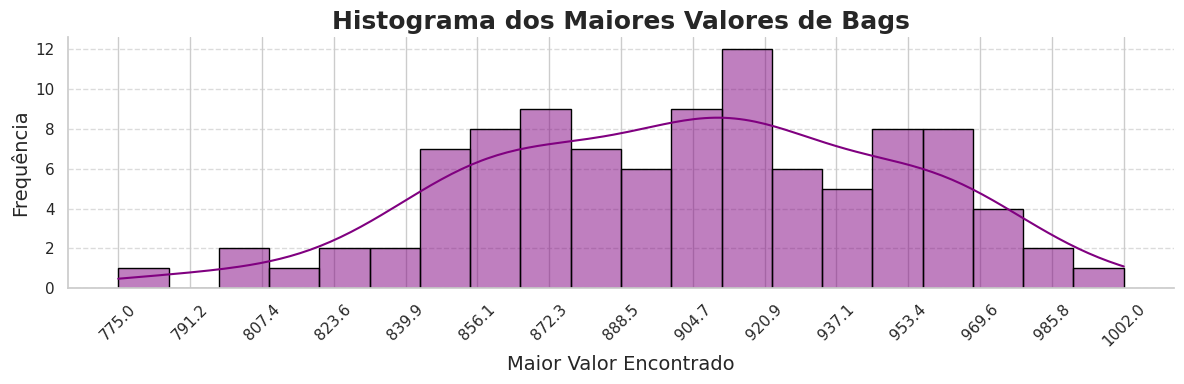

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

max_weights = results.groupby("bag")["value_current_bag"].max()

bins = 20

plt.figure(figsize=(12, 4))
sns.histplot(max_weights, bins=bins, color="purple", edgecolor="black", kde=True)

x_min, x_max = min(max_weights), max(max_weights)
x_ticks = np.linspace(x_min, x_max, num=15)  

plt.xticks(x_ticks, rotation=45)

plt.title("Histograma dos Maiores Valores de Bags", fontsize=18, fontweight="bold")
plt.xlabel("Maior Valor Encontrado", fontsize=14)
plt.ylabel("Frequência", fontsize=14)

sns.despine()
plt.grid(axis="y", linestyle="--", alpha=0.7)  

plt.tight_layout()
plt.show()

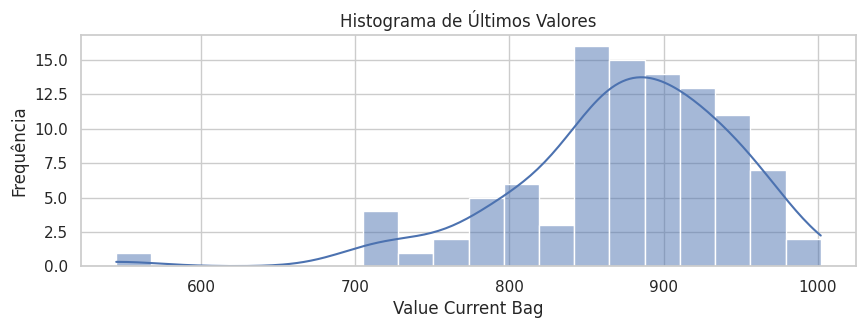

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

last_values = results[results["idx"] == 99]

plt.figure(figsize=(10, 3))
sns.histplot(last_values["value_current_bag"], bins=20, kde=True)
plt.title("Histograma de Últimos Valores")
plt.xlabel("Value Current Bag")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

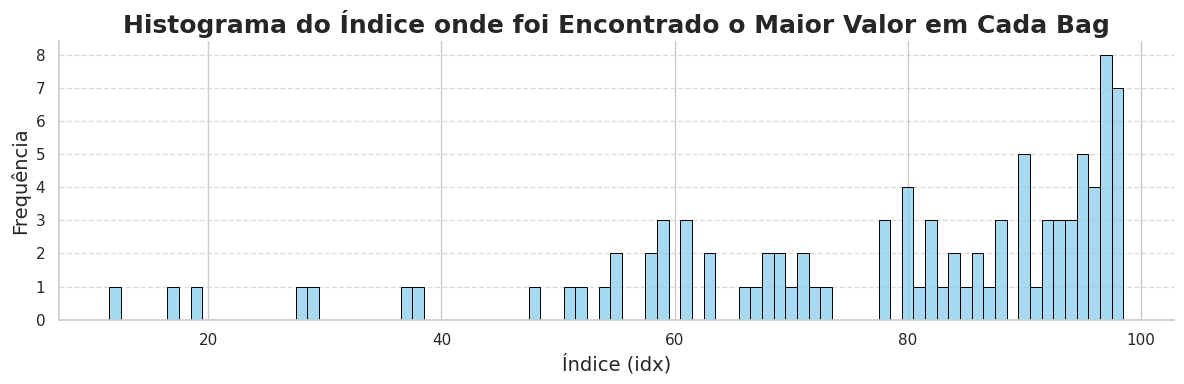

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

max_idx = results.loc[
    results.groupby("bag")["value_current_bag"].idxmax(), ["bag", "idx"]
]

bins = np.arange(max_idx["idx"].min() - 0.5, max_idx["idx"].max() + 0.5, 1)

plt.figure(figsize=(12, 4))
sns.histplot(max_idx["idx"], bins=bins, color="skyblue", edgecolor="black", kde=False)

plt.title(
    "Histograma do Índice onde foi Encontrado o Maior Valor em Cada Bag",
    fontsize=18,
    fontweight="bold",
)
plt.xlabel("Índice (idx)", fontsize=14)
plt.ylabel("Frequência", fontsize=14)

sns.despine()  
plt.grid(axis="y", linestyle="--", alpha=0.7)  

plt.tight_layout()
plt.show()

# Rodando para 10000 mochilas

In [49]:
import pandas as pd
import copy
from tqdm import tqdm

ROUNDS = 1000


data = {
    "round": [],
    "max_value": [],
    "better_idx": [],
    "last_values": []
}

for _round in tqdm(range(ROUNDS)):
    items = generate_items()
    initial_bag = generate_initial_bag(items)


    for bag in range(100):
        current_bag = copy.copy(initial_bag)  


        max_value = sum_values(current_bag)
        better_idx = 0
        last_value = 0

        for idx in range(100):
            randomic_annealing = None
            next_bag = sub_item(current_bag)

            weight_current_bag = sum_weights(current_bag)
            weight_next_bag = sum_weights(next_bag)

            value_current_bag = sum_values(current_bag)
            value_next_bag = sum_values(next_bag)
            

            next_is_better = next_is_better_value(current_bag, next_bag)

            if next_is_better:
                current_bag = next_bag
            else:
                randomic_annealing = randomic_annealing_value(idx)
                if randomic_annealing:
                    current_bag = next_bag
            

            if value_current_bag > max_value and weight_current_bag <= MAX_WEIGHT:
                max_value = value_current_bag
                better_idx = idx
        
        last_value = value_current_bag

        data["round"].append(_round)
        data["max_value"].append(max_value)
        data["better_idx"].append(better_idx)
        data["last_values"].append(last_value)

big_results = pd.DataFrame(data)


100%|██████████| 1000/1000 [26:09<00:00,  1.57s/it]


In [50]:
big_results.to_csv("big_results.csv", index=False)

## Histograma para 1000x

In [57]:
import pandas as pd

big_results = pd.read_csv("big_results.csv")

In [52]:
big_results

,round,max_value,better_idx,last_values
0,0,836,98,836
1,0,795,97,795
2,0,748,88,748
3,0,859,72,846
4,0,865,77,795
...,...,...,...,...
99995,999,970,99,970
99996,999,964,96,964
99997,999,983,96,983
99998,999,953,99,953


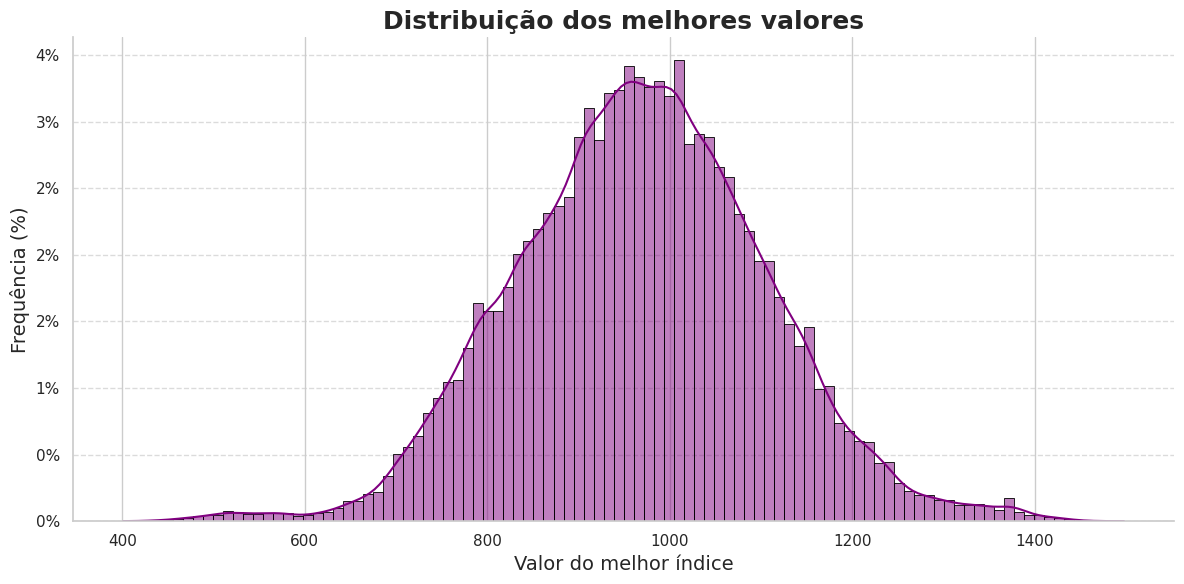

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(
    big_results["max_value"],
    bins=100,
    color="purple",
    edgecolor="black",
    kde=True,
    stat="probability",  
)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: "{:.0%}".format(y)))

plt.xticks(rotation=0)
plt.xlabel("Valor do melhor índice", fontsize=14)
plt.ylabel("Frequência (%)", fontsize=14)

plt.title("Distribuição dos melhores valores", fontsize=18, fontweight="bold")
sns.despine()

plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()

plt.show()

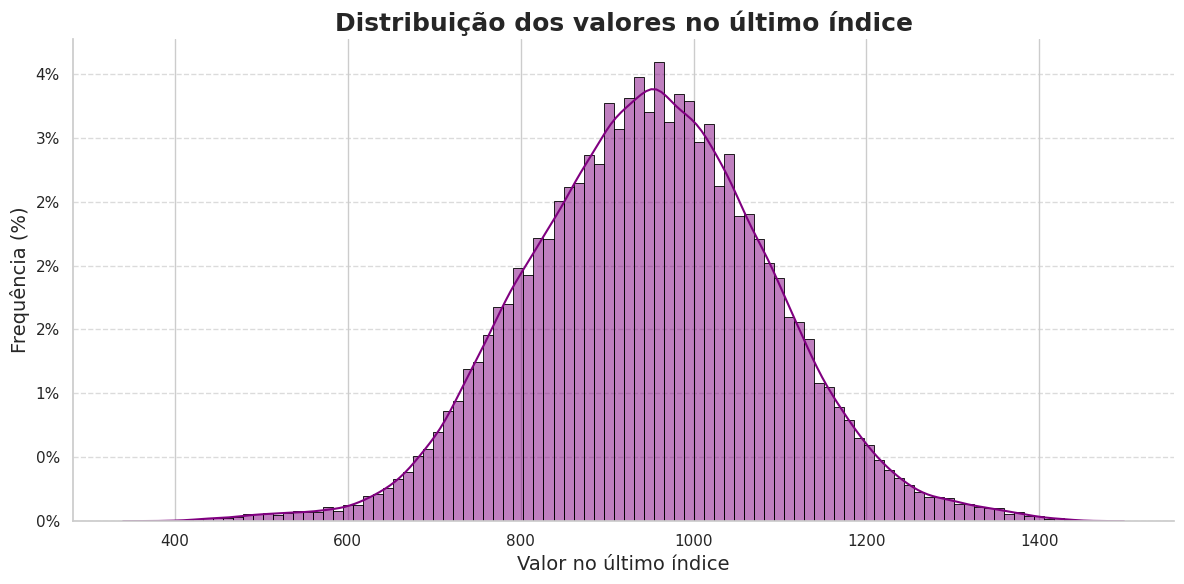

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(
    big_results["last_values"],
    bins=100,
    color="purple",
    edgecolor="black",
    kde=True,
    stat="probability",
)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: "{:.0%}".format(y)))

plt.xticks(rotation=0)
plt.xlabel("Valor no último índice", fontsize=14)
plt.ylabel("Frequência (%)", fontsize=14)

plt.title("Distribuição dos valores no último índice", fontsize=18, fontweight="bold")
sns.despine()

plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()

plt.show()

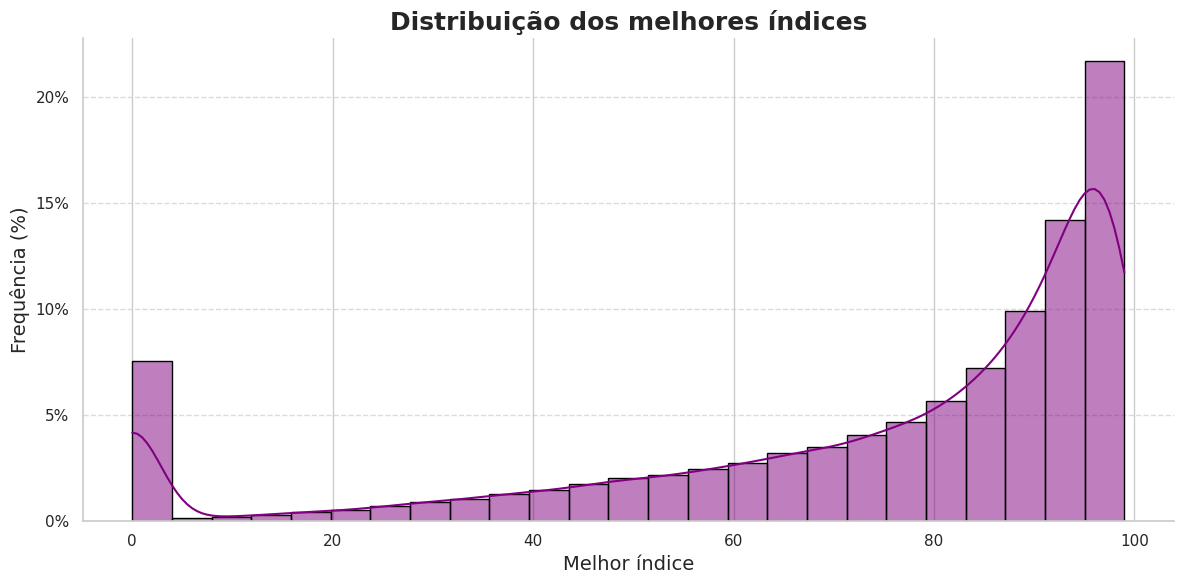

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(
    big_results["better_idx"],
    bins=25,
    color="purple",
    edgecolor="black",
    kde=True,
    stat="probability",
)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: "{:.0%}".format(y)))

plt.xticks(rotation=0)
plt.xlabel("Melhor índice", fontsize=14)
plt.ylabel("Frequência (%)", fontsize=14)

plt.title("Distribuição dos melhores índices", fontsize=18, fontweight="bold")
sns.despine()

plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()

plt.show()